In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Machine Learning Tutorials (37 Chapters)
# Chapter 4 — Supervised Learning Basics
## Lesson 4: Overfitting and Regularization (Ridge, LASSO, Elastic Net)

**What you will learn**
- What overfitting *actually* means in terms of generalization error and why it happens.
- How regularization modifies the learning objective and changes model capacity.
- The practical differences between **Ridge (L2)**, **LASSO (L1)**, and **Elastic Net (L1+L2)**.
- How to select regularization strength with clean validation and cross-validation.
- How to build end-to-end, leak-free pipelines on tabular datasets using scikit-learn.

**Datasets used in this lesson (chosen from your repo)**
- Regression: `house-prices.csv`, `diamonds.csv`
- Classification: `diabetes.csv`, `drug200.csv`

All dataset paths in code follow your repo structure, e.g. `../../../Datasets/Regression/house-prices.csv`.

---

### Lesson context inside Chapter 4
Chapter 4 contains **13 lessons** focused on supervised learning fundamentals. This lesson is about **controlling complexity** so that performance on *new* data remains strong.


## Table of Contents
1. Overfitting vs. Underfitting and Generalization
2. Bias–Variance View (Why Complexity Can Hurt)
3. Regularization as Penalized Empirical Risk Minimization
4. Ridge (L2): Shrinkage, Stability, and Correlated Features
5. LASSO (L1): Sparsity and Feature Selection
6. Elastic Net: Best of Both Worlds for High-Dimensional Problems
7. Worked Example A (Regression): House Prices — Ridge/LASSO/Elastic Net Pipelines
8. Worked Example B (Regression): Diamonds — High-cardinality categories + regularization
9. Worked Example C (Classification): Diabetes — Logistic Regression and Regularization
10. Worked Example D (Classification): Drug200 — One-hot explosion and L1/L2 tradeoffs
11. Practical Checklist: How to Avoid Overfitting in Real Projects
12. Exercises (Hands-on)


In [2]:
# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling tools
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression

# Reproducibility
RANDOM_STATE = 42

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [3]:
# Compatibility helpers for scikit-learn >=1.4 (avoid FutureWarnings)
try:
    # scikit-learn >= 1.4
    from sklearn.metrics import root_mean_squared_error as _sk_root_mse
    def rmse_score(y_true, y_pred):
        return _sk_root_mse(y_true, y_pred)
except Exception:
    # Older scikit-learn
    def rmse_score(y_true, y_pred):
        return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def get_feature_names_from_preprocessor(preprocessor, input_features=None):
    """Return output feature names for a fitted ColumnTransformer.

    Works across scikit-learn versions.
    """
    if hasattr(preprocessor, "get_feature_names_out"):
        try:
            return list(preprocessor.get_feature_names_out(input_features))
        except Exception:
            return list(preprocessor.get_feature_names_out())
    # Fallback: best-effort manual construction
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            try:
                names.extend(list(trans.get_feature_names_out(cols)))
            except Exception:
                names.extend(list(trans.get_feature_names_out()))
        else:
            # passthrough / scaler etc.
            if cols is None:
                continue
            if isinstance(cols, (list, tuple, np.ndarray, pd.Index)):
                names.extend([str(c) for c in cols])
            else:
                names.append(str(cols))
    return names


## 1) Overfitting vs. Underfitting and Generalization

A model **overfits** when it captures *idiosyncrasies* of the training data that do not persist in the data-generating process. This is not just "high training accuracy"; it is the situation where:

- training error is low, **but**
- validation/test error is significantly higher.

A model **underfits** when it is too rigid to capture the underlying signal; both training and test errors remain high.

### Why overfitting happens
Overfitting is encouraged by any combination of:
- **High model capacity** relative to dataset size (e.g., many free parameters, complex hypothesis class).
- **Noisy targets** or measurement errors.
- **Data leakage** (the model sees information about the target through features).
- **Hyperparameter tuning on the test set** (implicit leakage).
- **High-dimensional feature spaces**, especially with one-hot encoding and many rare categories.

### Generalization error
Let $\mathcal{D}$ be the population distribution and $\{(x_i, y_i)\}_{i=1}^n$ be an i.i.d. sample.
A learning algorithm produces parameters $\hat\theta$ by minimizing training loss:

$$
\hat\theta \in \arg\min_{\theta} \frac{1}{n} \sum_{i=1}^{n} \ell\big(f_{\theta}(x_i), y_i\big)
$$

The **generalization error** is the expected loss on new data:

$$
\mathcal{E}_{\text{gen}}(\hat\theta) = \mathbb{E}_{(x,y) \sim \mathcal{D}}\left[\ell\big(f_{\hat\theta}(x), y\big)\right]
$$

Regularization is one of the most direct ways to reduce the gap between training performance and generalization.


## 2) Bias–Variance View (Why Complexity Can Hurt)

For squared-error regression with target $y = f(x) + \epsilon$ and $\mathbb{E}[\epsilon]=0$, $\mathrm{Var}(\epsilon)=\sigma^2$, the expected test MSE at a point $x$ can be decomposed (conceptually) as:

$$
\mathbb{E}\left[(\hat f(x) - y)^2\right]
\approx \underbrace{\big(\mathbb{E}[\hat f(x)] - f(x)\big)^2}_{\text{Bias}^2}
+ \underbrace{\mathbb{E}\left[(\hat f(x) - \mathbb{E}[\hat f(x)])^2\right]}_{\text{Variance}}
+ \underbrace{\sigma^2}_{\text{Noise}}
$$

- **Increasing complexity** often reduces bias but increases variance.
- Overfitting is typically a **variance problem**: the model changes too much as training data changes.
- Regularization usually **increases bias slightly** but **reduces variance**, improving test performance.

A key mental model:  
> Regularization trades a small increase in bias for a (often large) reduction in variance.


## 3) Regularization as Penalized Empirical Risk Minimization

Regularization modifies the objective function by adding a penalty term that discourages overly complex solutions:

$$
\hat\theta \in \arg\min_{\theta}
\left[
\frac{1}{n} \sum_{i=1}^{n} \ell\big(f_{\theta}(x_i), y_i\big)
+ \lambda \; \Omega(\theta)
\right]
$$

- $\lambda \ge 0$ controls **regularization strength**.  
  - Large $\lambda$ forces simpler solutions.
  - Small $\lambda$ behaves closer to the unregularized estimator.
- $\Omega(\theta)$ is the **regularizer** (penalty function).

### The three regularizers we focus on
- **Ridge / L2**: $\Omega(\theta) = \lVert \theta \rVert_2^2$
- **LASSO / L1**: $\Omega(\theta) = \lVert \theta \rVert_1$
- **Elastic Net**: $\Omega(\theta) = \alpha \lVert \theta \rVert_1 + (1-\alpha)\lVert \theta \rVert_2^2$

Where $\alpha \in [0,1]$ (scikit-learn uses `l1_ratio`).

### Important practical note: scaling
For linear models, penalties depend on coefficient magnitude, so **feature scaling is mandatory** for fair regularization.
In practice: `StandardScaler` (for numeric features) + `OneHotEncoder` (for categorical features) inside a `Pipeline`.


## 4) Ridge (L2): Shrinkage, Stability, and Correlated Features

### Ridge regression objective
For linear regression with $\ell_2$ penalty:

$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2 + \lambda \lVert w \rVert_2^2
\right]
$$

### Closed-form solution (when features are numeric and not too large)
$$
\hat w = (X^\top X + \lambda I)^{-1} X^\top y
$$

### What Ridge does
- **Shrinks** coefficients toward zero, but typically does **not** set them exactly to zero.
- Handles **multicollinearity** (highly correlated predictors) better than ordinary least squares (OLS).
- Improves numerical stability when $X^\top X$ is near-singular.

### When Ridge is a strong default
- Many moderately useful features.
- Correlated predictors (common in real tabular data).
- You care about stable predictions more than a sparse set of features.


## 5) LASSO (L1): Sparsity and Feature Selection

### LASSO objective
$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2 + \lambda \lVert w \rVert_1
\right]
$$

### What LASSO does
- Encourages **sparsity**: many coefficients become **exactly zero**.
- Performs **embedded feature selection**, which can improve interpretability.

### Caveats
- With **strongly correlated features**, LASSO often selects one and drops others somewhat arbitrarily.
- In high-dimensional settings, LASSO may be unstable unless carefully cross-validated.
- Always scale numeric features. Without scaling, LASSO can eliminate “small-scale” features and keep “large-scale” ones for the wrong reasons.


## 6) Elastic Net: Combining L1 and L2

Elastic Net is designed to address LASSO’s behavior with correlated predictors and high-dimensional one-hot features.

### Elastic Net objective
$$
\hat w \in \arg\min_{w}
\left[
\frac{1}{n} \lVert Xw - y \rVert_2^2
+ \lambda \left( \alpha \lVert w \rVert_1 + (1-\alpha) \lVert w \rVert_2^2 \right)
\right]
$$

- $\alpha=1$ gives LASSO
- $\alpha=0$ gives Ridge
- Intermediate values blend both: group-like selection + shrinkage

**Rule of thumb**:
- If you have many correlated predictors or many sparse one-hot features, Elastic Net is often the best starting point.


## 7) A Visual Intuition: Polynomial Overfitting and How Regularization Helps

Before we touch real datasets, it is useful to *see* overfitting on a controlled example.

We generate data from a smooth function and fit polynomial regression of increasing degree.  
- High-degree polynomials can match training data extremely well, but they often generalize poorly.
- Adding Ridge penalty stabilizes the solution by shrinking coefficients, especially for higher-order terms.

In this section you will:
- Fit polynomial regression via feature expansion.
- Compare unregularized linear regression vs Ridge for the same polynomial features.
- Inspect training vs test error as complexity increases.


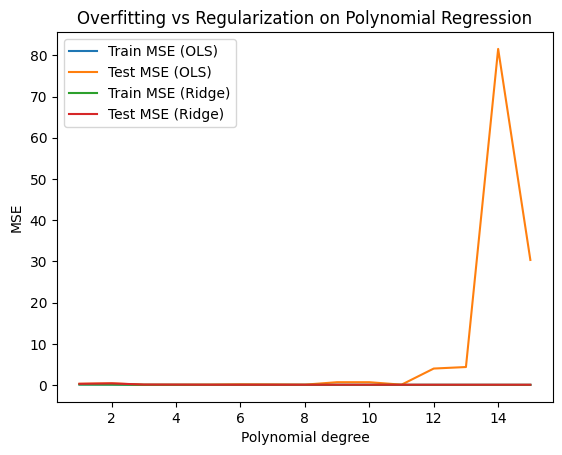

In [4]:
from sklearn.preprocessing import PolynomialFeatures

# Generate synthetic data
rng = np.random.default_rng(RANDOM_STATE)
n = 80
X = rng.uniform(-3, 3, size=(n, 1))
y_true = np.sin(X).ravel()
y = y_true + rng.normal(0, 0.25, size=n)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=RANDOM_STATE)

degrees = list(range(1, 16))
train_mse_ols, test_mse_ols = [], []
train_mse_ridge, test_mse_ridge = [], []

ridge_alpha = 1.0  # regularization strength for this toy demo

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=False)

    # Unregularized (OLS)
    model_ols = Pipeline([
        ("poly", poly),
        ("lr", LinearRegression())
    ])
    model_ols.fit(X_train, y_train)
    pred_tr = model_ols.predict(X_train)
    pred_te = model_ols.predict(X_test)
    train_mse_ols.append(mean_squared_error(y_train, pred_tr))
    test_mse_ols.append(mean_squared_error(y_test, pred_te))

    # Ridge on the same polynomial features (scaling helps for higher degrees)
    model_ridge = Pipeline([
        ("poly", poly),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=ridge_alpha))
    ])
    model_ridge.fit(X_train, y_train)
    pred_tr = model_ridge.predict(X_train)
    pred_te = model_ridge.predict(X_test)
    train_mse_ridge.append(mean_squared_error(y_train, pred_tr))
    test_mse_ridge.append(mean_squared_error(y_test, pred_te))

plt.figure()
plt.plot(degrees, train_mse_ols, label="Train MSE (OLS)")
plt.plot(degrees, test_mse_ols, label="Test MSE (OLS)")
plt.plot(degrees, train_mse_ridge, label="Train MSE (Ridge)")
plt.plot(degrees, test_mse_ridge, label="Test MSE (Ridge)")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.title("Overfitting vs Regularization on Polynomial Regression")
plt.legend()
plt.show()

**How to read the plot**

- OLS training MSE generally decreases as degree increases.
- OLS test MSE typically decreases at first (better fit) and then increases (overfitting).
- Ridge typically has slightly higher training error but often lower test error for higher degrees.

This is a clean microcosm of what happens in real-world problems:
- Complex models can memorize patterns that do not generalize.
- Regularization reduces sensitivity to noise and stabilizes estimates.


## 8) Worked Example A (Regression): House Prices — Ridge/LASSO/Elastic Net Pipelines

Dataset: `../../../Datasets/Regression/house-prices.csv`  
Target: `Price`

This dataset includes:
- numeric predictors: `SqFt`, `Bedrooms`, `Bathrooms`, `Offers`
- categorical predictors: `Brick`, `Neighborhood`

We will:
1. Build a **baseline** linear regression pipeline.
2. Build **Ridge**, **LASSO**, and **Elastic Net** pipelines.
3. Use **cross-validation** to choose regularization strength.
4. Compare RMSE/MAE/$R^2$ on a held-out test set.

### Why a Pipeline matters
We must avoid leakage: scaling/encoding must be fit on training data only, then applied to test data.
`Pipeline` + `ColumnTransformer` ensures this automatically.


In [5]:
# Load house prices dataset
path_house = "../../../Datasets/Regression/house-prices.csv"
df_house = pd.read_csv(path_house)
df_house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [6]:
# Separate features and target
target = "Price"
X = df_house.drop(columns=[target])
y = df_house[target]

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

numeric_features, categorical_features

(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers'],
 ['Brick', 'Neighborhood'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# Baseline OLS
pipe_ols = Pipeline([
    ("preprocess", preprocess),
    ("model", LinearRegression())
])

pipe_ols.fit(X_train, y_train)
pred = pipe_ols.predict(X_test)

rmse = rmse_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

rmse, mae, r2


(np.float64(10277.325457328316),
 np.float64(8338.003966571283),
 0.8276990005561011)

### RidgeCV / LassoCV / ElasticNetCV

We will tune hyperparameters using cross-validation:
- Ridge: `alpha` (strength of $\ell_2$ shrinkage)
- LASSO: `alpha` (strength of $\ell_1$ penalty)
- Elastic Net: `alpha` and `l1_ratio`

In scikit-learn, many estimators use slightly different naming conventions:
- `Ridge(alpha=...)` uses `alpha` directly.
- `LogisticRegression(C=...)` uses $C = 1/\lambda$ (inverse regularization strength).

Below we use log-spaced grids so we can explore both weak and strong regularization.


In [8]:
alphas = np.logspace(-4, 4, 50)

pipe_ridge = Pipeline([
    ("preprocess", preprocess),
    ("model", RidgeCV(alphas=alphas, cv=5))
])

pipe_ridge.fit(X_train, y_train)
pred = pipe_ridge.predict(X_test)

rmse_ridge = rmse_score(y_test, pred)
mae_ridge = mean_absolute_error(y_test, pred)
r2_ridge = r2_score(y_test, pred)

best_alpha_ridge = pipe_ridge.named_steps["model"].alpha_

rmse_ridge, mae_ridge, r2_ridge, best_alpha_ridge


(np.float64(10246.6350647865),
 np.float64(8315.966264364932),
 0.8287265227021609,
 np.float64(1.7575106248547894))

In [9]:
# LASSO needs scaling (handled in preprocess) and often benefits from more iterations.
pipe_lasso = Pipeline([
    ("preprocess", preprocess),
    ("model", LassoCV(alphas=alphas, cv=5, max_iter=20000, random_state=RANDOM_STATE))
])

pipe_lasso.fit(X_train, y_train)
pred = pipe_lasso.predict(X_test)

rmse_lasso = rmse_score(y_test, pred)
mae_lasso = mean_absolute_error(y_test, pred)
r2_lasso = r2_score(y_test, pred)

best_alpha_lasso = pipe_lasso.named_steps["model"].alpha_

rmse_lasso, mae_lasso, r2_lasso, best_alpha_lasso


(np.float64(10314.602229887927),
 np.float64(8352.332188246926),
 0.826446831735808,
 np.float64(339.3221771895323))

In [10]:
l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]

pipe_enet = Pipeline([
    ("preprocess", preprocess),
    ("model", ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5, max_iter=20000, random_state=RANDOM_STATE))
])

pipe_enet.fit(X_train, y_train)
pred = pipe_enet.predict(X_test)

rmse_enet = rmse_score(y_test, pred)
mae_enet = mean_absolute_error(y_test, pred)
r2_enet = r2_score(y_test, pred)

best_alpha_enet = pipe_enet.named_steps["model"].alpha_
best_l1_ratio = pipe_enet.named_steps["model"].l1_ratio_

rmse_enet, mae_enet, r2_enet, best_alpha_enet, best_l1_ratio


(np.float64(10253.460418787085),
 np.float64(8323.70452683701),
 0.8284982738289953,
 np.float64(0.12648552168552957),
 np.float64(0.9))

### Compare models on the same test split

Interpretation:
- If the dataset is small and features are correlated, Ridge often improves RMSE stability.
- LASSO may win if some features are truly irrelevant and should be zeroed out.
- Elastic Net is a robust choice when you are unsure, especially if one-hot encoding creates many correlated dummy variables.


In [11]:
results = pd.DataFrame({
    "Model": ["OLS", "Ridge", "LASSO", "ElasticNet"],
    "RMSE": [rmse, rmse_ridge, rmse_lasso, rmse_enet],
    "MAE": [mae, mae_ridge, mae_lasso, mae_enet],
    "R2": [r2, r2_ridge, r2_lasso, r2_enet],
})
results.sort_values("RMSE")

,Model,RMSE,MAE,R2
1,Ridge,10246.635065,8315.966264,0.828727
3,ElasticNet,10253.460419,8323.704527,0.828498
0,OLS,10277.325457,8338.003967,0.827699
2,LASSO,10314.602230,8352.332188,0.826447


### Coefficients and shrinkage

Regularization is easiest to understand by looking at coefficients.

- Ridge typically shrinks all coefficients toward zero.
- LASSO/Elastic Net can produce exact zeros (sparse solutions).
- With categorical variables (one-hot), interpretation is “relative to baseline category.”

Below we extract feature names from the preprocessing step and display the largest coefficients by magnitude.


In [12]:
# Helper to get feature names after preprocessing (robust across scikit-learn versions)
pre = pipe_enet.named_steps["preprocess"]
feature_names = get_feature_names_from_preprocessor(pre, input_features=X_train.columns if hasattr(X_train, "columns") else None)

def top_coefficients(pipe, top_k=15):
    coef = pipe.named_steps["model"].coef_
    s = pd.Series(coef, index=feature_names).sort_values(key=np.abs, ascending=False)
    return s.head(top_k)

top_coefficients(pipe_ridge, 12), top_coefficients(pipe_lasso, 12), top_coefficients(pipe_enet, 12)


(cat__Neighborhood_West     12783.540134
 num__SqFt                  12606.249622
 num__Offers                -9753.236009
 cat__Brick_No              -7988.279682
 cat__Brick_Yes              7988.279682
 cat__Neighborhood_East     -7341.973361
 cat__Neighborhood_North    -5441.566773
 num__Bathrooms              3756.691396
 num__Bedrooms               3156.365612
 num__Home                   -247.322643
 dtype: float64,
 cat__Neighborhood_West     1.978515e+04
 cat__Brick_No             -1.486040e+04
 num__SqFt                  1.234131e+04
 num__Offers               -9.230231e+03
 num__Bathrooms             3.518110e+03
 num__Bedrooms              2.828537e+03
 cat__Brick_Yes             1.186322e-11
 num__Home                 -0.000000e+00
 cat__Neighborhood_East    -0.000000e+00
 cat__Neighborhood_North   -0.000000e+00
 dtype: float64,
 cat__Neighborhood_West     12994.790574
 num__SqFt                  12703.164545
 num__Offers                -9770.373762
 cat__Brick_No         

### Ridge coefficient path (regularization path)

A *regularization path* shows how coefficients change as $\lambda$ (or `alpha`) increases.

- For Ridge: coefficients continuously shrink.
- For LASSO: coefficients can abruptly drop to exactly zero.

Below we compute a Ridge path by fitting many alphas and plotting coefficient magnitude versus $\log_{10}(\alpha)$.


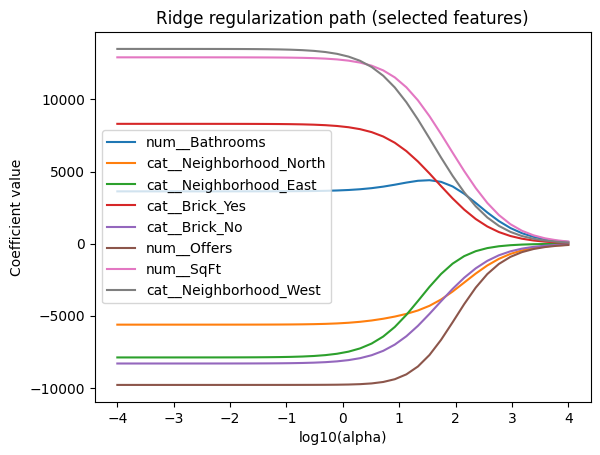

In [13]:
from sklearn.base import clone

alphas_path = np.logspace(-4, 4, 40)
coef_path = []

for a in alphas_path:
    pipe_tmp = Pipeline([
        ("preprocess", preprocess),
        ("model", Ridge(alpha=a))
    ])
    pipe_tmp.fit(X_train, y_train)
    coef_path.append(pipe_tmp.named_steps["model"].coef_)

coef_path = np.array(coef_path)  # shape: (n_alphas, n_features_after_preprocess)

# Plot only the largest-magnitude coefficients from the best ElasticNet model for readability
enet_coefs = pipe_enet.named_steps["model"].coef_
idx = np.argsort(np.abs(enet_coefs))[-8:]  # 8 most relevant features

plt.figure()
for j in idx:
    plt.plot(np.log10(alphas_path), coef_path[:, j], label=feature_names[j])
plt.xlabel("log10(alpha)")
plt.ylabel("Coefficient value")
plt.title("Ridge regularization path (selected features)")
plt.legend()
plt.show()

## 9) Worked Example B (Regression): Diamonds — Categories + Regularization

Dataset: `../../../Datasets/Regression/diamonds.csv`  
Target: `price`

Why this dataset is interesting for regularization:
- Mixture of numeric and categorical features (`cut`, `color`, `clarity`).
- Potentially many rows; linear models scale well, but preprocessing still matters.
- One-hot encoding produces correlated dummy variables; Ridge/Elastic Net often shine.

We will:
- Build an OLS baseline.
- Compare Ridge vs Elastic Net with cross-validation.
- Use sampling if the dataset is large (purely for speed).


In [14]:
path_diamonds = "../../../Datasets/Regression/diamonds.csv"
df_diamonds = pd.read_csv(path_diamonds)

# If dataset is very large, sample for faster experiments (still demonstrates the method).
if len(df_diamonds) > 50000:
    df_diamonds = df_diamonds.sample(50000, random_state=RANDOM_STATE)

df_diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
1388,1389,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,50053,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,41646,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,42378,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,17245,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [15]:
target = "price"
X = df_diamonds.drop(columns=[target])
y = df_diamonds[target]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocess_d = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

pipe_ols_d = Pipeline([("preprocess", preprocess_d), ("model", LinearRegression())])
pipe_ridge_d = Pipeline([("preprocess", preprocess_d), ("model", RidgeCV(alphas=np.logspace(-3, 3, 30), cv=5))])
pipe_enet_d = Pipeline([("preprocess", preprocess_d), ("model", ElasticNetCV(alphas=np.logspace(-3, 3, 30), l1_ratio=[0.2,0.5,0.8], cv=5, max_iter=20000, random_state=RANDOM_STATE))])

for name, pipe in [("OLS", pipe_ols_d), ("RidgeCV", pipe_ridge_d), ("ElasticNetCV", pipe_enet_d)]:
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    rmse = rmse_score(y_test, pred)
    r2 = r2_score(y_test, pred)
    print(name, "RMSE:", round(rmse, 2), "R2:", round(r2, 3))

print("Best Ridge alpha:", pipe_ridge_d.named_steps["model"].alpha_)
print("Best ElasticNet alpha:", pipe_enet_d.named_steps["model"].alpha_, "l1_ratio:", pipe_enet_d.named_steps["model"].l1_ratio_)


OLS RMSE: 1112.05 R2: 0.922
RidgeCV RMSE: 1111.53 R2: 0.922
ElasticNetCV RMSE: 1111.94 R2: 0.922
Best Ridge alpha: 22.122162910704503
Best ElasticNet alpha: 0.0041753189365604 l1_ratio: 0.8


## 10) Worked Example C (Classification): Diabetes — Logistic Regression and Regularization

Dataset: `../../../Datasets/Classification/diabetes.csv`  
Target: `classification` (e.g., `Diabetic` vs `Non-Diabetic`)

For linear classification, logistic regression is a standard baseline. Regularization is *critical* because:
- features can be correlated,
- datasets can be small,
- class imbalance can occur,
- coefficients can become unstable without penalties.

### Logistic regression with L2 penalty
The regularized objective (binary case) can be written as:

$$
\min_{w,b}
\left[
\frac{1}{n} \sum_{i=1}^{n} \log\big(1 + \exp(-y_i (w^\top x_i + b))\big)
+ \lambda \lVert w \rVert_2^2
\right]
$$

In scikit-learn, you usually tune `C`, where $C = 1/\lambda$:
- smaller `C` → stronger regularization
- larger `C` → weaker regularization


In [16]:
path_diabetes = "../../../Datasets/Classification/diabetes.csv"
df_diabetes = pd.read_csv(path_diabetes)
df_diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [17]:
# Diabetes dataset: robust label encoding + dedicated train/test variables (avoid collisions with other sections)
target = "classification"
X_diab = df_diabetes.drop(columns=[target]).copy()
y_diab = df_diabetes[target].astype(str).copy()

# Convert to binary labels robustly.
# IMPORTANT: do NOT use `.contains("diabetic")` because "Non-Diabetic" also contains "diabetic".
y_norm = (
    y_diab.astype(str)
          .str.strip()
          .str.lower()
          .str.replace(r"[\s_]+", "", regex=True)
          .str.replace("–", "-")
          .str.replace("—", "-")
)

y_bin = np.where(
    y_norm.isin(["diabetic", "1", "yes", "true"]),
    1,
    np.where(y_norm.isin(["nondiabetic", "non-diabetic", "0", "no", "false"]), 0, np.nan)
)
y_bin = pd.Series(y_bin, index=y_diab.index).astype("float")

# If there are any unknown labels, drop them (keeps notebook robust to dataset variations).
if y_bin.isna().any():
    keep = ~y_bin.isna()
    X_diab = X_diab.loc[keep].reset_index(drop=True)
    y_bin = y_bin.loc[keep].reset_index(drop=True)

y_bin = y_bin.astype(int)

# Quick sanity check
display(y_bin.value_counts().rename("class_counts"))

Xd_train, Xd_test, yd_train, yd_test = train_test_split(
    X_diab, y_bin, test_size=0.25, random_state=RANDOM_STATE, stratify=y_bin
)

# Identify column types (even if dataset changes and includes categoricals)
diab_num = Xd_train.select_dtypes(include=[np.number]).columns.tolist()
diab_cat = [c for c in Xd_train.columns if c not in diab_num]

from sklearn.compose import ColumnTransformer
preprocess_diab = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), diab_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), diab_cat),
    ],
    remainder="drop"
)

diab_num, diab_cat


0    500
1    268
Name: class_counts, dtype: int64

(['Pregnancies',
  'Glucose',
  'BloodPressure',
  'SkinThickness',
  'Insulin',
  'BMI',
  'DiabetesPedigreeFunction',
  'Age'],
 [])

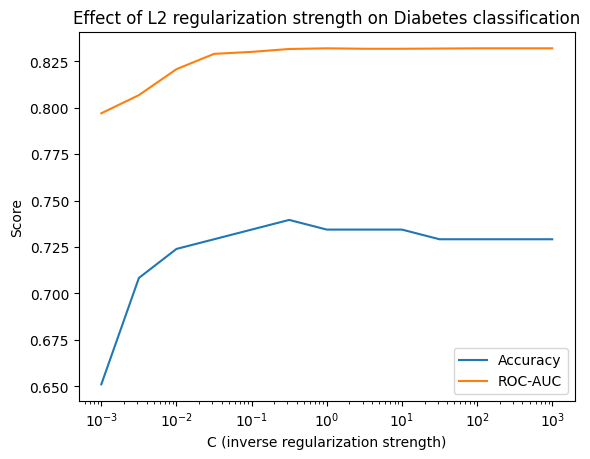

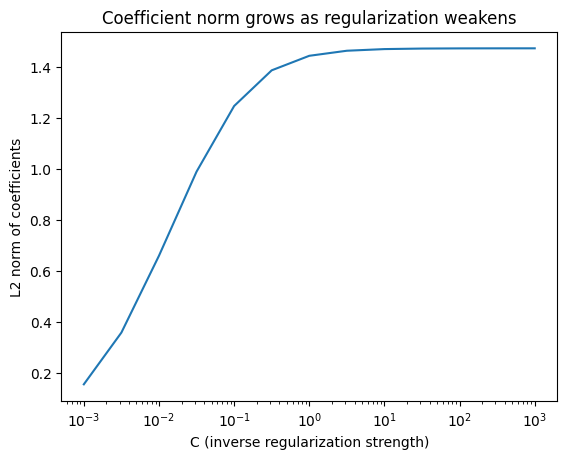

In [18]:
# Compare several C values for L2-regularized logistic regression (Diabetes)
Cs = np.logspace(-3, 3, 13)
accs, aucs, coef_norms = [], [], []

for C in Cs:
    pipe = Pipeline([
        ("preprocess", preprocess_diab),
        ("clf", LogisticRegression(C=C, penalty="l2", solver="lbfgs", max_iter=5000))
    ])
    pipe.fit(Xd_train, yd_train)
    proba = pipe.predict_proba(Xd_test)[:, 1]
    pred = (proba >= 0.5).astype(int)

    accs.append(accuracy_score(yd_test, pred))

    # ROC-AUC requires both classes in yd_test
    aucs.append(roc_auc_score(yd_test, proba) if len(np.unique(yd_test)) == 2 else np.nan)

    coef = pipe.named_steps["clf"].coef_.ravel()
    coef_norms.append(np.linalg.norm(coef, ord=2))

plt.figure()
plt.semilogx(Cs, accs, label="Accuracy")
plt.semilogx(Cs, aucs, label="ROC-AUC")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Score")
plt.title("Effect of L2 regularization strength on Diabetes classification")
plt.legend()
plt.show()

plt.figure()
plt.semilogx(Cs, coef_norms)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("L2 norm of coefficients")
plt.title("Coefficient norm grows as regularization weakens")
plt.show()


**Interpretation**
- As `C` increases (weaker regularization), the coefficient norm generally increases.
- Performance may improve up to a point and then degrade due to overfitting.
- In practice, you would pick `C` using cross-validation on the training set, not by peeking at the test set. The above is a didactic visualization.

Next, we show L1 vs L2. For L1 in scikit-learn, `solver="saga"` is commonly used.


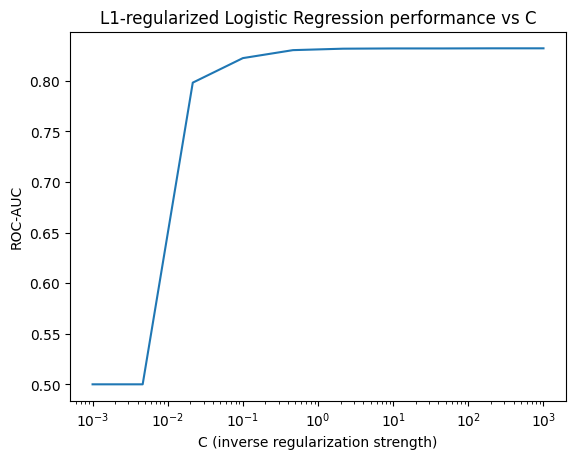

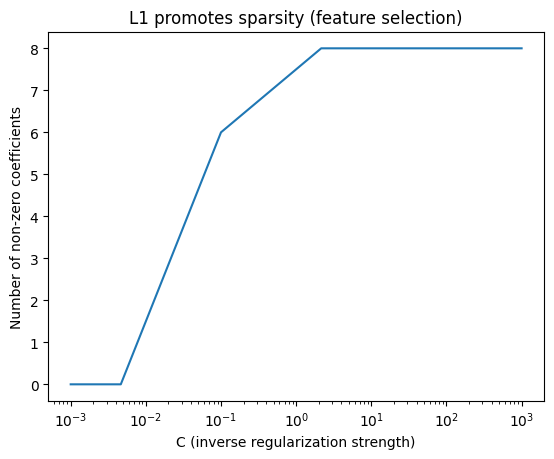

In [19]:
# L1 vs C (sparsity demo) using the same preprocessing (Diabetes)
Cs = np.logspace(-3, 3, 10)
nonzero_counts = []
test_scores = []

for C in Cs:
    pipe = Pipeline([
        ("preprocess", preprocess_diab),
        ("clf", LogisticRegression(C=C, penalty="l1", solver="saga", max_iter=8000))
    ])
    pipe.fit(Xd_train, yd_train)
    proba = pipe.predict_proba(Xd_test)[:, 1]

    # ROC-AUC requires both classes in yd_test
    test_scores.append(roc_auc_score(yd_test, proba) if len(np.unique(yd_test)) == 2 else np.nan)

    coef = pipe.named_steps["clf"].coef_.ravel()
    nonzero_counts.append(np.sum(np.abs(coef) > 1e-8))

plt.figure()
plt.semilogx(Cs, test_scores)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("ROC-AUC")
plt.title("L1-regularized Logistic Regression performance vs C")
plt.show()

plt.figure()
plt.semilogx(Cs, nonzero_counts)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Number of non-zero coefficients")
plt.title("L1 promotes sparsity (feature selection)")
plt.show()


## 11) Worked Example D (Classification): Drug200 — One-Hot Explosion and Regularization

Dataset: `../../../Datasets/Classification/drug200.csv`  
Target: `Drug` (multi-class)

This dataset is a classic example where:
- several predictors are categorical (`Sex`, `BP`, `Cholesterol`),
- one-hot encoding expands the feature space,
- regularization prevents the classifier from assigning extreme weights to rare categories.

We will train multi-class logistic regression with:
- L2 penalty (stable)
- L1 penalty (sparse; can select useful categories)

We will use a clean preprocessing pipeline:
- numeric: `StandardScaler`
- categorical: `OneHotEncoder(handle_unknown="ignore")`


In [20]:
path_drug = "../../../Datasets/Classification/drug200.csv"
df_drug = pd.read_csv(path_drug)
df_drug.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


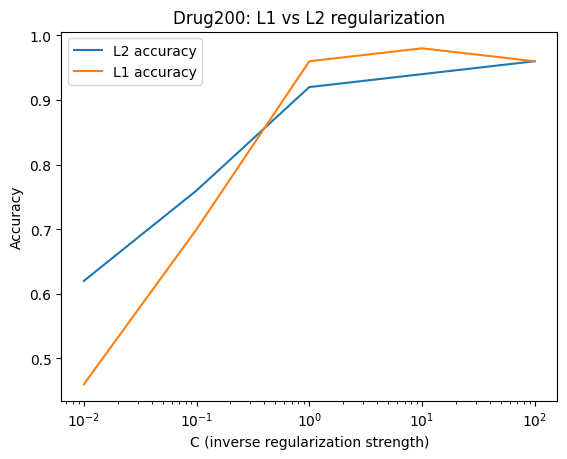

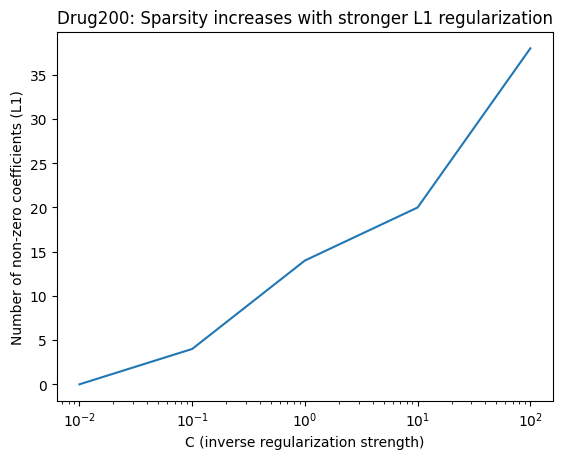

In [21]:
target = "Drug"
X = df_drug.drop(columns=[target])
y = df_drug[target].astype(str)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X.columns if c not in numeric_features]

preprocess_drug = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

def fit_eval_logreg(penalty, C):
    # 'saga' supports multinomial + l1/l2
    pipe = Pipeline([
        ("preprocess", preprocess_drug),
        ("clf", LogisticRegression(
            penalty=penalty,
            C=C,
            solver="saga",
            max_iter=8000,
        ))
    ])
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return pipe, acc

Cs = [0.01, 0.1, 1, 10, 100]
acc_l2, acc_l1, nz_l1 = [], [], []

for C in Cs:
    _, a2 = fit_eval_logreg("l2", C)
    pipe_l1, a1 = fit_eval_logreg("l1", C)
    acc_l2.append(a2)
    acc_l1.append(a1)

    # Count non-zero coefficients for L1 model (sparsity)
    coef = pipe_l1.named_steps["clf"].coef_
    nz_l1.append(np.sum(np.abs(coef) > 1e-8))

plt.figure()
plt.semilogx(Cs, acc_l2, label="L2 accuracy")
plt.semilogx(Cs, acc_l1, label="L1 accuracy")
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Accuracy")
plt.title("Drug200: L1 vs L2 regularization")
plt.legend()
plt.show()

plt.figure()
plt.semilogx(Cs, nz_l1)
plt.xlabel("C (inverse regularization strength)")
plt.ylabel("Number of non-zero coefficients (L1)")
plt.title("Drug200: Sparsity increases with stronger L1 regularization")
plt.show()


## 12) Practical Checklist: How to Avoid Overfitting (and Use Regularization Correctly)

### A. Split discipline
- Keep a true **test set** untouched until the end.
- Do all preprocessing inside the training pipeline.
- If data has time ordering or groups, use appropriate splits (time-series split, group split).

### B. Regularization selection
- Choose $\lambda$ (or `alpha` / `C`) using cross-validation on training data.
- Prefer log-spaced grids (e.g., $10^{-4}$ to $10^{4}$) when you do not know the right scale.

### C. Scaling and encoding
- Always scale numeric features for Ridge/LASSO/Elastic Net and logistic regression.
- For categorical features, use one-hot encoding and consider:
  - collapsing rare categories,
  - hashing tricks (advanced),
  - stronger regularization if one-hot dimensionality is large.

### D. Interpretability vs performance
- Ridge: stable, good default, not sparse.
- LASSO: sparse, can be unstable under collinearity.
- Elastic Net: often best for high-dimensional / correlated features.

### E. Sanity checks for leakage
- If test performance is “too good to be true,” validate that:
  - target or post-outcome variables are not in features,
  - preprocessing is not fit on the full dataset,
  - duplicates are not split across train/test,
  - you did not tune hyperparameters based on test results.


## 13) (Optional) From-Scratch Ridge Regression (Numeric Features Only)

To deepen intuition, implement the Ridge closed-form solution:

$$
\hat w = (X^\top X + \lambda I)^{-1} X^\top y
$$

This is only practical for:
- numeric features,
- not-too-large feature dimension,
- dense matrices.

We will use a simple numeric-only regression dataset: `cognitive.csv`.


In [22]:
path_cog = "../../../Datasets/Regression/cognitive.csv"
df_cog = pd.read_csv(path_cog)
df_cog.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,yes,121.117529,yes,27
1,98,yes,89.361882,yes,25
2,85,yes,115.443165,yes,27
3,83,yes,99.449639,yes,25
4,115,yes,92.745710,yes,27


In [ ]:
# Predict kid_score using numeric-coded features
# We'll convert yes/no to 1/0 for simplicity (still numeric).
df = df_cog.copy()
for col in ["mom_hs", "mom_work"]:
    df[col] = (df[col].astype(str).str.lower() == "yes").astype(int)

X = df.drop(columns=["kid_score"]).to_numpy(dtype=float)
y = df["kid_score"].to_numpy(dtype=float)

# Train/test split
idx = np.arange(len(df))
rng = np.random.default_rng(RANDOM_STATE)
rng.shuffle(idx)
split = int(0.75 * len(idx))
tr_idx, te_idx = idx[:split], idx[split:]

X_train, X_test = X[tr_idx], X[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

# Standardize numeric features (important for ridge)
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0) + 1e-12
X_train_s = (X_train - mu) / sd
X_test_s = (X_test - mu) / sd

def ridge_closed_form(X, y, lam):
    # X: (n, d), y: (n,)
    n, d = X.shape
    A = X.T @ X + lam * np.eye(d)
    b = X.T @ y
    w = np.linalg.solve(A, b)
    return w

lams = np.logspace(-4, 3, 30)
test_rmse = []
coef_norm = []

for lam in lams:
    w = ridge_closed_form(X_train_s, y_train, lam)
    pred = X_test_s @ w
    test_rmse.append(rmse_score(y_test, pred))
    coef_norm.append(np.linalg.norm(w))

plt.figure()
plt.semilogx(lams, test_rmse)
plt.xlabel("lambda")
plt.ylabel("Test RMSE")
plt.title("Ridge closed-form: effect of lambda on generalization")
plt.show()

plt.figure()
plt.semilogx(lams, coef_norm)
plt.xlabel("lambda")
plt.ylabel("L2 norm of coefficients")
plt.title("Ridge closed-form: coefficient norm shrinks with lambda")
plt.show()


## 14) Exercises

These exercises are designed to ensure you can apply regularization in a principled, leak-free way.

### Exercise 1 — Ridge vs LASSO vs Elastic Net (House Prices)
1. Use a new random split (`random_state=123`) and re-run the three models.
2. Report RMSE and $R^2$.
3. Compare the stability of the selected hyperparameters across splits.

### Exercise 2 — Regularization path and interpretability
1. For the house dataset, compute a LASSO path by fitting multiple `alpha` values.
2. Plot the coefficients versus $\log_{10}(\alpha)$ for the top 10 features.
3. Which features “survive” the strongest regularization?

### Exercise 3 — Nested cross-validation (model selection without leakage)
1. Use an outer 5-fold CV to estimate performance.
2. Inside each training fold, pick `alpha` (or `C`) via inner CV.
3. Compare the nested-CV estimate to the single split test estimate.

### Exercise 4 — One-hot explosion and sparsity (Drug200)
1. Count how many one-hot features are created.
2. Compare the number of non-zero coefficients for L1 vs L2 at the same `C`.
3. Explain (in a short paragraph) why L1 might be more interpretable here.

### Exercise 5 — What if scaling is omitted?
1. Re-run LASSO for house prices without scaling numeric features.
2. Observe how the chosen `alpha` and coefficients change.
3. Explain why scaling changes the optimization geometry.

If you complete these exercises, you will have operational mastery of regularization for classical supervised learning on tabular data.


## 15) Summary

- Overfitting is fundamentally a **generalization** problem and often manifests as high **variance**.
- Regularization adds constraints that stabilize parameter estimates:
  - Ridge (L2): shrinkage, stability, good default, handles correlation well.
  - LASSO (L1): sparsity and embedded feature selection, but can be unstable with correlated predictors.
  - Elastic Net: combines both; often strong for one-hot and correlated feature spaces.
- Correct practice requires:
  - strict train/validation/test hygiene,
  - preprocessing inside pipelines,
  - cross-validation for hyperparameter selection.

In the next lessons of Chapter 4, these ideas connect directly to:
- evaluation metrics,
- bias–variance tradeoff,
- feature engineering for linear models (polynomial and interaction terms),
- GLMs and multi-class extensions.
